In [26]:
# ===== 超参数配置 =====


class Config:
    # 数据相关
    seq_length = 96      # 输入序列长度（96个时间点，24小时，每点15分钟）
    pred_length = 16         # 预测序列长度（16个时间点，4小时）
    train_val_split = 0.8  # 训练验证集分割比例
    
    # 数据加载
    batch_size = 128          # 批大小
    num_workers = 8          # 数据加载器工作进程数
    
    # 风电功率特征工程相关
    time_interval_minutes = 15   
    use_feature_engineering = True  # 是否使用特征工程

    add_trend_features = True        # 趋势特征

    add_lag_features = True        # 添加滞后特征
    lag_steps = [1, 2 , 4, 8, 16, 24, 48, 96]  
    
    add_ramp_features = True      # 添加功率爬坡特征
    ramp_windows = [4, 8, 16]       # 爬坡检测窗口

    add_anomaly_features = True     # 异常检测特征
    anomaly_windows = [24, 96]       # 异常检测的滚动窗口大小

    add_statistical_features = True  # 统计滚动特征
    statistical_windows = [4, 8, 16, 24, 48, 96]  # 统计特征的滚动窗口大小
    enable_rolling_mean = True       # 启用滚动均值
    enable_rolling_std = True        # 启用滚动标准差
    enable_rolling_max = True        # 启用滚动最大值
    enable_rolling_min = True        # 启用滚动最小值
    enable_rolling_range = True      # 启用滚动范围

    input_size = 1           # 输入特征维度（将在特征工程后动态计算）
    hidden_size = 128       # LSTM隐藏层大小
    num_layers = 2          # LSTM层数
    output_size = 16         
    dropout = 0.3       
    
    use_attention = True       
    attention_heads = 8   
    use_residual = True   
    residual_weight = 0.1    # 残差连接权重
    
    # 训练相关
    num_epochs = 1000        
    learning_rate = 0.01    
    weight_decay = 1e-4      # 权重衰减

    huber_delta = 1.0       # Huber损失函数的delta参数
    
    # 学习率调度
    lr_patience = 10         # 学习率调度耐心值
    lr_factor = 0.5          # 学习率衰减因子
    
    # 早停机制
    early_stop_patience = 20 # 早停耐心值
    early_stop_min_delta = 0.0001 # CR指标最小改善幅度
    
    # 其他
    random_seed = 42         # 随机种子
    gpu_device = '1'         # 使用的GPU设备
    print_freq = 100         # 训练时打印频率
    
    # 路径配置
    data_dir = '../data'
    model_save_dir = '../lstm/models'
    results_dir = '../lstm/results'
    
# 创建配置实例
config = Config()

print("=== Hyperparameter Configuration ===")
print(f"Time Configuration: {config.seq_length} points ({config.seq_length * config.time_interval_minutes / 60:.1f}h) -> {config.pred_length} points ({config.pred_length * config.time_interval_minutes / 60:.1f}h)")
print(f"Feature Engineering: Enabled={config.use_feature_engineering}")
print(f"Model Structure: {config.num_layers} LSTM layers, Hidden size {config.hidden_size}, Dropout {config.dropout}")
print(f"Training Config: Batch size {config.batch_size}, Learning rate {config.learning_rate}, Max epochs {config.num_epochs}")
print(f"Early Stopping: Patience {config.early_stop_patience}, Min delta {config.early_stop_min_delta}")
print("=" * 50)

=== Hyperparameter Configuration ===
Time Configuration: 96 points (24.0h) -> 16 points (4.0h)
Feature Engineering: Enabled=True
Model Structure: 2 LSTM layers, Hidden size 128, Dropout 0.3
Training Config: Batch size 128, Learning rate 0.01, Max epochs 1000
Early Stopping: Patience 20, Min delta 0.0001


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 使用config中的GPU设置
os.environ['CUDA_VISIBLE_DEVICES'] = config.gpu_device

# 设置随机种子确保可重现性
np.random.seed(config.random_seed)
torch.manual_seed(config.random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.random_seed)
    torch.cuda.manual_seed_all(config.random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} (GPU {config.gpu_device})')
if torch.cuda.is_available():
    print(f'GPU device: {torch.cuda.get_device_name(0)}')
    print(f'GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')


Using device: cuda (GPU 1)
GPU device: NVIDIA RTX A6000
GPU memory: 47.44 GB


In [28]:
# 加载数据
train_data = pd.read_excel(f'{config.data_dir}/train.xlsx')
test_data = pd.read_excel(f'{config.data_dir}/test.xlsx')

# 提取功率数据（第一列是实际功率）
train_power = train_data.iloc[:, 0].values
test_power = test_data.iloc[:, 0].values

print(f"Training data length: {len(train_power)}")
print(f"Testing data length: {len(test_power)}")
print(f"Training data range: [{train_power.min():.4f}, {train_power.max():.4f}]")
print(f"Testing data range: [{test_power.min():.4f}, {test_power.max():.4f}]")

# 检查原始数据中的负数情况
train_negative_count = np.sum(train_power < 0)
test_negative_count = np.sum(test_power < 0)
print(f"Original negative values in training data: {train_negative_count}")
print(f"Original negative values in testing data: {test_negative_count}")
if train_negative_count > 0 or test_negative_count > 0:
    print("Negative values will be converted to 0 during preprocessing")

# 数据预处理（简化版：数据已经归一化，只需处理负值）
def simplified_data_preprocessing(data, config):
    """简化的数据预处理：只处理负值转换为0"""
    processed_data = data.copy()
    
    # 将负数转换为0（这是唯一需要的预处理步骤）
    processed_data = np.where(processed_data < 0, 0, processed_data)
    
    print(f"Processed data range: [{processed_data.min():.4f}, {processed_data.max():.4f}]")
    negative_count = np.sum(data < 0)
    if negative_count > 0:
        print(f"Converted {negative_count} negative values to 0")
    else:
        print("No negative values found")
    
    return processed_data, None  # 返回None作为scaler（不需要）

# 应用简化预处理
if config.use_feature_engineering:
    print("\n=== Simplified Data Preprocessing ===")
    train_power_processed, train_scaler = simplified_data_preprocessing(train_power, config)
    test_power_processed, test_scaler = simplified_data_preprocessing(test_power, config)
    
    print(f"Final training data range: [{train_power_processed.min():.4f}, {train_power_processed.max():.4f}]")
    print(f"Final testing data range: [{test_power_processed.min():.4f}, {test_power_processed.max():.4f}]")
else:
    # 即使不使用特征工程，也需要简单的负值处理
    train_power_processed = np.where(train_power < 0, 0, train_power)
    test_power_processed = np.where(test_power < 0, 0, test_power)
    train_scaler = None
    test_scaler = None
    print("Applied basic negative value conversion only")





Training data length: 6999
Testing data length: 2999
Training data range: [-0.0094, 1.0000]
Testing data range: [-0.0093, 0.9446]
Original negative values in training data: 445
Original negative values in testing data: 138
Negative values will be converted to 0 during preprocessing

=== Simplified Data Preprocessing ===
Processed data range: [0.0000, 1.0000]
Converted 445 negative values to 0
Processed data range: [0.0000, 0.9446]
Converted 138 negative values to 0
Final training data range: [0.0000, 1.0000]
Final testing data range: [0.0000, 0.9446]


In [29]:
# 数据集类定义
class EnhancedPowerDataset(Dataset):
    def __init__(self, data, seq_length=96, pred_length=16, step=1, config=None):
        """
        增强的电力数据集类（支持全面特征工程）
        
        参数:
        data: 原始时间序列数据
        seq_length: 输入序列长度
        pred_length: 预测序列长度
        step: 滑动窗口步长
        config: 配置对象
        """
        self.data = data
        self.seq_length = seq_length
        self.pred_length = pred_length
        self.step = step
        self.config = config
        
        # 创建特征
        if config and config.use_feature_engineering:
            self.features, self.feature_names = self._create_enhanced_features()
            print(f"Created {self.features.shape[1]} features: {len(self.feature_names)} total")
            print(f"Feature categories: {self._get_feature_categories()}")
            
            # 特征选择（如果启用）
            if getattr(config, 'enable_feature_selection', False) and self.features.shape[1] > config.max_features:
                self.features, self.feature_names = self._apply_feature_selection()
                print(f"After feature selection: {self.features.shape[1]} features")
        else:
            self.features = data.reshape(-1, 1)
            self.feature_names = ['power']
        
        # 创建输入输出对
        self.X, self.y = self._create_sequences()

    def _get_feature_categories(self):
        """获取特征类别统计"""
        categories = {}
        for name in self.feature_names:
            if name == 'power':
                category = 'original'
            elif name.startswith('lag_'):
                category = 'lag'
            elif name.startswith('ramp_'):
                category = 'ramp'
            elif name.startswith('rolling_'):
                category = 'statistical'
            elif 'outlier' in name or 'anomaly' in name:
                category = 'anomaly'
            elif name.endswith(('_sin', '_cos')) or 'time' in name or 'hour' in name or 'weekday' in name or 'month' in name or 'season' in name:
                category = 'temporal'
            elif name.startswith(('diff_', 'pct_', 'cumulative_', 'relative_')):
                category = 'trend'
            elif name.startswith('power_level_') or name in ['zero_power', 'full_power', 'power_level_change']:
                category = 'power_state'
            elif name.startswith(('volatility_', 'cv_', 'skewness_', 'kurtosis_')):
                category = 'volatility'
            elif name.startswith(('diff_historical_', 'ratio_historical_')) or name == 'is_weekend':
                category = 'cross_temporal'
            elif name in ['dominant_frequency', 'spectral_energy']:
                category = 'frequency'
            else:
                category = 'other'
            
            categories[category] = categories.get(category, 0) + 1
        
        return categories


    def add_trend_features(self, power_series):
        """添加趋势和变化率特征（归一化版本）"""
        features = []
        feature_names = []
        
        # 一阶差分（变化率）- 归一化
        diff_1 = power_series.diff(1).fillna(0)
        # 裁剪到合理范围并归一化到[-1, 1]
        diff_1_normalized = np.clip(diff_1.values, -0.5, 0.5)
        features.append(diff_1_normalized)
        feature_names.append('diff_1')
        
        # 二阶差分（加速度）- 归一化
        diff_2 = power_series.diff(2).fillna(0)
        # 裁剪到合理范围并归一化到[-1, 1]
        diff_2_normalized = np.clip(diff_2.values, -0.3, 0.3)
        features.append(diff_2_normalized)
        feature_names.append('diff_2')
        
        return features, feature_names


    def add_statistical_features(self, power_series):
        """添加统计滚动窗口特征（使用config中的窗口参数）"""
        features = []
        feature_names = []
        
        # 使用config中的统计窗口参数
        windows = self.config.statistical_windows
        
        for window in windows:
            # 滚动均值
            if self.config.enable_rolling_mean:
                rolling_mean = power_series.rolling(window=window, min_periods=1).mean().fillna(0).values
                features.append(rolling_mean)
                feature_names.append(f'rolling_mean_{window}')
            
            # 滚动标准差
            if self.config.enable_rolling_std:
                rolling_std = power_series.rolling(window=window, min_periods=1).std().fillna(0).values
                features.append(rolling_std)
                feature_names.append(f'rolling_std_{window}')
            
            # 滚动最大值
            if self.config.enable_rolling_max:
                rolling_max = power_series.rolling(window=window, min_periods=1).max().fillna(0).values
                features.append(rolling_max)
                feature_names.append(f'rolling_max_{window}')
            
            # 滚动最小值
            if self.config.enable_rolling_min:
                rolling_min = power_series.rolling(window=window, min_periods=1).min().fillna(0).values
                features.append(rolling_min)
                feature_names.append(f'rolling_min_{window}')
            
            # 滚动范围（max - min）
            if self.config.enable_rolling_range and self.config.enable_rolling_max and self.config.enable_rolling_min:
                rolling_max = power_series.rolling(window=window, min_periods=1).max().fillna(0).values
                rolling_min = power_series.rolling(window=window, min_periods=1).min().fillna(0).values
                rolling_range = rolling_max - rolling_min
                features.append(rolling_range)
                feature_names.append(f'rolling_range_{window}')
        
        return features, feature_names

    def add_anomaly_features(self, power_series):
        """添加异常检测特征（使用config中的窗口参数）"""
        features = []
        feature_names = []
        
        # Z-score异常检测
        z_scores = np.abs((power_series - power_series.mean()) / power_series.std())
        is_outlier = (z_scores > 2).astype(int).values  # 2个标准差外为异常
        features.append(is_outlier)
        feature_names.append('is_outlier')
        
        # IQR异常检测
        Q1 = power_series.quantile(0.25)
        Q3 = power_series.quantile(0.75)
        IQR = Q3 - Q1
        is_iqr_outlier = ((power_series < (Q1 - 1.5 * IQR)) | 
                          (power_series > (Q3 + 1.5 * IQR))).astype(int).values
        features.append(is_iqr_outlier)
        feature_names.append('is_iqr_outlier')
        
        # 局部异常因子（使用config中的异常窗口参数）
        windows = self.config.anomaly_windows
        for window in windows:
            local_mean = power_series.rolling(window=window, center=True).mean()
            local_std = power_series.rolling(window=window, center=True).std()
            local_anomaly = np.abs(power_series - local_mean) > (2 * local_std)
            features.append(local_anomaly.fillna(0).astype(int).values)
            feature_names.append(f'local_anomaly_{window}')
        
        return features, feature_names
    
    def _apply_feature_selection(self):
        """应用特征选择"""
        from sklearn.feature_selection import VarianceThreshold
        
        # 方差阈值过滤
        selector = VarianceThreshold(threshold=0.001)
        features_filtered = selector.fit_transform(self.features)
        selected_features = [name for i, name in enumerate(self.feature_names) 
                            if selector.get_support()[i]]
        
        # 如果仍然超过最大特征数，随机选择
        if len(selected_features) > self.config.max_features:
            np.random.seed(self.config.random_seed)
            indices = np.random.choice(len(selected_features), self.config.max_features, replace=False)
            features_filtered = features_filtered[:, indices]
            selected_features = [selected_features[i] for i in indices]
        
        return features_filtered, selected_features
    
    def _create_enhanced_features(self):
        """创建增强的特征（完整版）"""
        features = []
        feature_names = []
        
        power_series = pd.Series(self.data)
        
        # 1. 原始功率数据
        features.append(self.data)
        feature_names.append('power')
        
        # 2. 滞后特征
        if self.config.add_lag_features:
            for lag in self.config.lag_steps:
                if lag < len(self.data):
                    lag_feature = np.roll(self.data, lag)
                    lag_feature[:lag] = lag_feature[lag]
                    features.append(lag_feature)
                    feature_names.append(f'lag_{lag}')
        
        # 3. 功率爬坡特征
        if self.config.add_ramp_features:
            for window in self.config.ramp_windows:
                # 功率爬坡率：单位时间内功率变化幅度
                ramp_rate = power_series.diff(window).fillna(0).values
                features.append(ramp_rate)
                feature_names.append(f'ramp_rate_{window}')
                
                # 绝对爬坡率
                abs_ramp_rate = np.abs(ramp_rate)
                features.append(abs_ramp_rate)
                feature_names.append(f'abs_ramp_rate_{window}')
                
                # 功率爬坡强度（滚动窗口内最大绝对变化）
                ramp_intensity = power_series.diff().abs().rolling(window=window, min_periods=1).max().fillna(0).values
                features.append(ramp_intensity)
                feature_names.append(f'ramp_intensity_{window}')
                
                # 爬坡方向（上升=1，下降=-1，稳定=0）
                ramp_direction = np.sign(ramp_rate)
                features.append(ramp_direction)
                feature_names.append(f'ramp_direction_{window}')
        
        # 4. 统计滚动特征
        if self.config.add_statistical_features:
            stat_features, stat_names = self.add_statistical_features(power_series)
            features.extend(stat_features)
            feature_names.extend(stat_names)

        # 5. 异常检测特征
        if self.config.add_anomaly_features:
            anomaly_features, anomaly_names = self.add_anomaly_features(power_series)
            features.extend(anomaly_features)
            feature_names.extend(anomaly_names)
        
        
        # 6. 新增：趋势特征
        if getattr(self.config, 'add_trend_features', True):
            trend_features, trend_names = self.add_trend_features(power_series)
            features.extend(trend_features)
            feature_names.extend(trend_names)
        
    
        return np.array(features).T, feature_names  # [time_steps, num_features]
    
    def _create_sequences(self):
        X, y = [], []
        for i in range(0, len(self.data) - self.seq_length - self.pred_length + 1, self.step):
            # 多特征输入序列
            X.append(self.features[i:i + self.seq_length])
            # 输出序列（仍然是原始功率数据）
            y.append(self.data[i + self.seq_length:i + self.seq_length + self.pred_length])
        return np.array(X), np.array(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])




# 创建训练数据集
print("Creating training dataset...")
train_dataset = EnhancedPowerDataset(
    data=train_power_processed,
    seq_length=config.seq_length,
    pred_length=config.pred_length,
    step=1,
    config=config
)

print(f"Training dataset created successfully!")
print(f"Dataset length: {len(train_dataset)}")
print(f"Features shape: {train_dataset.features.shape}")
print(f"Input sequences shape: {train_dataset.X.shape}")
print(f"Target sequences shape: {train_dataset.y.shape}")

# 创建测试数据集
print("\nCreating test dataset...")
test_dataset = EnhancedPowerDataset(
    data=test_power_processed,
    seq_length=config.seq_length,
    pred_length=config.pred_length,
    step=1,
    config=config
)

print(f"Test dataset created successfully!")
print(f"Dataset length: {len(test_dataset)}")
print(f"Features shape: {test_dataset.features.shape}")
print(f"Input sequences shape: {test_dataset.X.shape}")
print(f"Target sequences shape: {test_dataset.y.shape}")

# 更新config中的input_size
config.input_size = train_dataset.features.shape[1]
print(f"\nUpdated config.input_size to: {config.input_size}")

# 显示特征统计信息
print(f"\nFeature Engineering Summary:")
print(f"✅ Total features created: {len(train_dataset.feature_names)}")
print(f"✅ Feature categories: {train_dataset._get_feature_categories()}")

# 检查特征范围（不进行归一化）
print(f"\nFeature Statistics (Raw Features - No Normalization):")
print(f"Features range: [{train_dataset.features.min():.6f}, {train_dataset.features.max():.6f}]")
print(f"Features mean: {train_dataset.features.mean():.6f}")
print(f"Features std: {train_dataset.features.std():.6f}")
print(f"Target values range: [{train_dataset.data.min():.6f}, {train_dataset.data.max():.6f}]")

# 检查是否有异常值
has_nan = np.isnan(train_dataset.features).any()
has_inf = np.isinf(train_dataset.features).any()
has_very_large = np.any(np.abs(train_dataset.features) > 1e6)

print(f"\nData Quality Check:")
print(f"Has NaN values: {has_nan}")
print(f"Has Inf values: {has_inf}")
print(f"Has very large values (>1e6): {has_very_large}")

if has_nan or has_inf or has_very_large:
    print("⚠️  WARNING: Found problematic values in features!")
    print("🔧 Applying safe replacement (NaN/Inf → 0)...")
    train_dataset.features = np.nan_to_num(train_dataset.features, nan=0.0, posinf=0.0, neginf=0.0)
    test_dataset.features = np.nan_to_num(test_dataset.features, nan=0.0, posinf=0.0, neginf=0.0)
    
    # 重新创建序列
    train_dataset.X, train_dataset.y = train_dataset._create_sequences()
    test_dataset.X, test_dataset.y = test_dataset._create_sequences()
    print("✅ Problematic values replaced, sequences recreated")
else:
    print("✅ No problematic values found")



# 创建数据加载器
print("\n" + "="*60)
print("CREATING DATA LOADERS")


# 分割训练集和验证集
train_size = int(config.train_val_split * len(train_dataset))
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(train_dataset)))

train_dataset_split = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(train_dataset, val_indices)

# 创建数据加载器
train_loader = DataLoader(train_dataset_split, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

print(f"Training set size: {len(train_dataset_split)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

print(f"Total features: {len(train_dataset.feature_names)}")
print(f"Feature categories: {train_dataset._get_feature_categories()}")
print(f"Ready for training!")

Creating training dataset...
Created 57 features: 57 total
Feature categories: {'original': 1, 'lag': 8, 'ramp': 9, 'other': 3, 'statistical': 30, 'anomaly': 4, 'trend': 2}


Training dataset created successfully!
Dataset length: 6888
Features shape: (6999, 57)
Input sequences shape: (6888, 96, 57)
Target sequences shape: (6888, 16)

Creating test dataset...
Created 57 features: 57 total
Feature categories: {'original': 1, 'lag': 8, 'ramp': 9, 'other': 3, 'statistical': 30, 'anomaly': 4, 'trend': 2}
Test dataset created successfully!
Dataset length: 2888
Features shape: (2999, 57)
Input sequences shape: (2888, 96, 57)
Target sequences shape: (2888, 16)

Updated config.input_size to: 57

Feature Engineering Summary:
✅ Total features created: 57
✅ Feature categories: {'original': 1, 'lag': 8, 'ramp': 9, 'other': 3, 'statistical': 30, 'anomaly': 4, 'trend': 2}

Feature Statistics (Raw Features - No Normalization):
Features range: [-1.000000, 1.000000]
Features mean: 0.167196
Features std: 0.321856
Target values range: [0.000000, 1.000000]

Data Quality Check:
Has NaN values: False
Has Inf values: False
Has very large values (>1e6): False
✅ No problematic value

In [30]:
# LSTM模型定义
class MultiStepLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, output_size=16, dropout=0.2, 
                 attention_heads=8, residual_weight=0.1, use_attention=True, use_residual=True):
        super(MultiStepLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.residual_weight = residual_weight
        self.use_attention = use_attention  
        self.use_residual = use_residual  
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # 条件创建注意力机制
        if self.use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=hidden_size,
                num_heads=attention_heads,
                dropout=dropout,
                batch_first=True
            )
        
        # 全连接层
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size)
        )
        
        # 条件创建残差连接用的线性层
        if self.use_residual:
            self.residual_fc = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # LSTM前向传播
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # 条件使用注意力机制
        if self.use_attention:
            attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
            last_output = attn_out[:, -1, :]
        else:
            # 直接使用LSTM输出的最后一个时间步
            last_output = lstm_out[:, -1, :]
        
        # 全连接层预测
        prediction = self.fc_layers(last_output)
        
        # 条件使用残差连接
        if self.use_residual:
            residual = self.residual_fc(x[:, -1, :]).squeeze(-1)
            output = prediction + residual * self.residual_weight
        else:
            # 不使用残差连接，直接返回预测结果
            output = prediction
        
        return output
   
    
    def get_parameter_count(self):
        """获取详细的参数统计信息"""
        total_params = 0
        trainable_params = 0
        param_details = {}
        
        for name, param in self.named_parameters():
            param_count = param.numel()
            total_params += param_count
            
            if param.requires_grad:
                trainable_params += param_count
            
            # 按模块分类参数
            module_name = name.split('.')[0]
            if module_name not in param_details:
                param_details[module_name] = 0
            param_details[module_name] += param_count
        
        return {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'non_trainable_params': total_params - trainable_params,
            'param_details': param_details
        }


# 使用config中的参数创建模型
# 使用config中的参数创建模型
model = MultiStepLSTM(
    input_size=config.input_size,
    hidden_size=config.hidden_size,
    num_layers=config.num_layers,
    output_size=config.output_size,
    dropout=config.dropout,
    attention_heads=config.attention_heads,
    residual_weight=config.residual_weight,
    use_attention=config.use_attention,
    use_residual=config.use_residual  
).to(device)

# 获取详细的模型参数信息
param_info = model.get_parameter_count()

print("=" * 60)
print("模型参数详细统计信息")
print("=" * 60)
print(f"总参数量: {param_info['total_params']:,}")
print(f"可训练参数: {param_info['trainable_params']:,}")
print(f"不可训练参数: {param_info['non_trainable_params']:,}")
print(f"\n各模块参数分布:")
for module, count in param_info['param_details'].items():
    percentage = (count / param_info['total_params']) * 100
    print(f"  {module:15}: {count:>10,} ({percentage:5.1f}%)")

# 计算模型大小（MB）
model_size_mb = param_info['total_params'] * 4 / (1024 * 1024)  # 假设每个参数4字节（float32）
print(f"\n模型大小估计: {model_size_mb:.2f} MB")
print(f"模型结构:")
print(model)
print("=" * 60)

模型参数详细统计信息
总参数量: 362,800
可训练参数: 362,800
不可训练参数: 0

各模块参数分布:
  lstm           :    227,840 ( 62.8%)
  attention      :     66,048 ( 18.2%)
  fc_layers      :     67,984 ( 18.7%)
  residual_fc    :        928 (  0.3%)

模型大小估计: 1.38 MB
模型结构:
MultiStepLSTM(
  (lstm): LSTM(57, 128, num_layers=2, batch_first=True, dropout=0.3)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=16, bias=True)
  )
  (residual_fc): Linear(in_features=57, out_features=16, bias=True)
)


In [31]:

# 使用Huber损失函数，对异常值更加鲁棒
criterion = nn.HuberLoss(delta=config.huber_delta)  # delta参数控制从平方损失切换到线性损失的阈值
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

# 学习率调度器（使用config参数）
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=config.lr_factor, patience=config.lr_patience, verbose=True
)

# 基于CR指标的早停机制（使用config参数）
class CRBasedEarlyStopping:
    def __init__(self, patience=20, min_delta=0.1, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta  # CR指标最小改善幅度
        self.restore_best_weights = restore_best_weights
        self.best_cr = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_cr, model):
        if self.best_cr is None:
            self.best_cr = val_cr
            self.save_checkpoint(model)
        elif val_cr > self.best_cr + self.min_delta:  # CR指标越高越好
            self.best_cr = val_cr
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

early_stopping = CRBasedEarlyStopping(
    patience=config.early_stop_patience, 
    min_delta=config.early_stop_min_delta
)

print(f"Optimizer config: AdamW, lr={config.learning_rate}, weight_decay={config.weight_decay}")
print(f"Loss function: Huber Loss (delta={config.huber_delta})")
print(f"Learning rate scheduler: patience={config.lr_patience}, factor={config.lr_factor}")
print(f"Early stopping config: patience={config.early_stop_patience}, min_delta={config.early_stop_min_delta}")


Optimizer config: AdamW, lr=0.01, weight_decay=0.0001
Loss function: Huber Loss (delta=1.0)
Learning rate scheduler: patience=10, factor=0.5
Early stopping config: patience=20, min_delta=0.0001


In [32]:
# 训练函数（使用config参数）
def train_epoch(model, train_loader, criterion, optimizer, device, config):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
        
        if batch_idx % config.print_freq == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
    
    return total_loss / len(train_loader)

# 验证函数
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

# 计算验证集CR指标的函数
def calculate_validation_cr(model, val_loader, device):
    """计算验证集上的CR指标"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            all_predictions.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    # 计算整体CR指标
    cr_overall = calculate_CR(targets.flatten(), predictions.flatten())
    
    return cr_overall

# 新增：计算逐步验证集CR指标的函数
def calculate_stepwise_validation_cr(model, val_loader, device):
    """计算验证集上每个预测步长的CR指标"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            all_predictions.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    # 计算每个预测步长的CR指标
    stepwise_cr = []
    for step in range(predictions.shape[1]):
        step_targets = targets[:, step]
        step_predictions = predictions[:, step]
        cr = calculate_CR(step_targets, step_predictions)
        stepwise_cr.append(cr)
    
    return stepwise_cr

# CR指标计算函数
def calculate_CR(PM, PP):
    """
    计算CR指标（准确度指标）
    
    参数:
    PM: 实际值数组
    PP: 预测值数组
    
    返回:
    CR: CR指标值（百分比）
    """
    N = len(PM)
    Ri = np.zeros(N)
    for i in range(N):
        if PM[i] > 0.2:
            Ri[i] = (PM[i] - PP[i]) / PM[i]
        else:
            Ri[i] = (PM[i] - PP[i]) / 0.2
    rms_error = np.sqrt(np.mean(Ri**2))
    CR = (1 - rms_error) * 100
    return CR

print(f"Training configuration loaded: Print frequency {config.print_freq}")

Training configuration loaded: Print frequency 100


In [33]:
# 开始训练
train_losses = []
val_losses = []
val_cr_scores = []
val_cr_stepwise = []  # 新增：逐步CR记录

print("Starting training...")
print(f"Training epochs: {config.num_epochs}")
print(f"Batch size: {config.batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print("Early stopping strategy: Based on CR metric (higher CR is better)")
print("=" * 50)

for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch+1}/{config.num_epochs}")
    
    # 训练
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, config)
    train_losses.append(train_loss)
    
    # 验证
    val_loss = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # 计算验证集CR指标
    val_cr = calculate_validation_cr(model, val_loader, device)
    val_cr_scores.append(val_cr)
    
    # 新增：计算逐步CR指标
    stepwise_cr = calculate_stepwise_validation_cr(model, val_loader, device)
    val_cr_stepwise.append(stepwise_cr)
    
    # 学习率调度（仍基于损失）
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    print(f"Validation CR: {val_cr:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # 基于CR指标的早停检查
    if early_stopping(val_cr, model):
        print(f"\nEarly stopping triggered! Training stopped at epoch {epoch+1}")
        print(f"Best CR metric: {early_stopping.best_cr:.2f}%")
        break

print("\nTraining completed!")
print(f"Best validation CR: {early_stopping.best_cr:.2f}%")

Starting training...
Training epochs: 1000
Batch size: 128
Learning rate: 0.01
Early stopping strategy: Based on CR metric (higher CR is better)

Epoch 1/1000
  Batch 0/44, Loss: 0.075833
Train Loss: 0.085933, Val Loss: 0.006407
Validation CR: 58.93%
Current LR: 1.00e-02

Epoch 2/1000
  Batch 0/44, Loss: 0.009130
Train Loss: 0.009188, Val Loss: 0.005657
Validation CR: 59.19%
Current LR: 1.00e-02

Epoch 3/1000
  Batch 0/44, Loss: 0.010736
Train Loss: 0.008005, Val Loss: 0.005603
Validation CR: 57.47%
Current LR: 1.00e-02

Epoch 4/1000
  Batch 0/44, Loss: 0.007974
Train Loss: 0.007507, Val Loss: 0.005643
Validation CR: 56.71%
Current LR: 1.00e-02

Epoch 5/1000
  Batch 0/44, Loss: 0.007552
Train Loss: 0.007130, Val Loss: 0.006214
Validation CR: 52.64%
Current LR: 1.00e-02

Epoch 6/1000
  Batch 0/44, Loss: 0.004744
Train Loss: 0.006782, Val Loss: 0.004678
Validation CR: 65.68%
Current LR: 1.00e-02

Epoch 7/1000
  Batch 0/44, Loss: 0.006952
Train Loss: 0.006598, Val Loss: 0.005656
Validatio

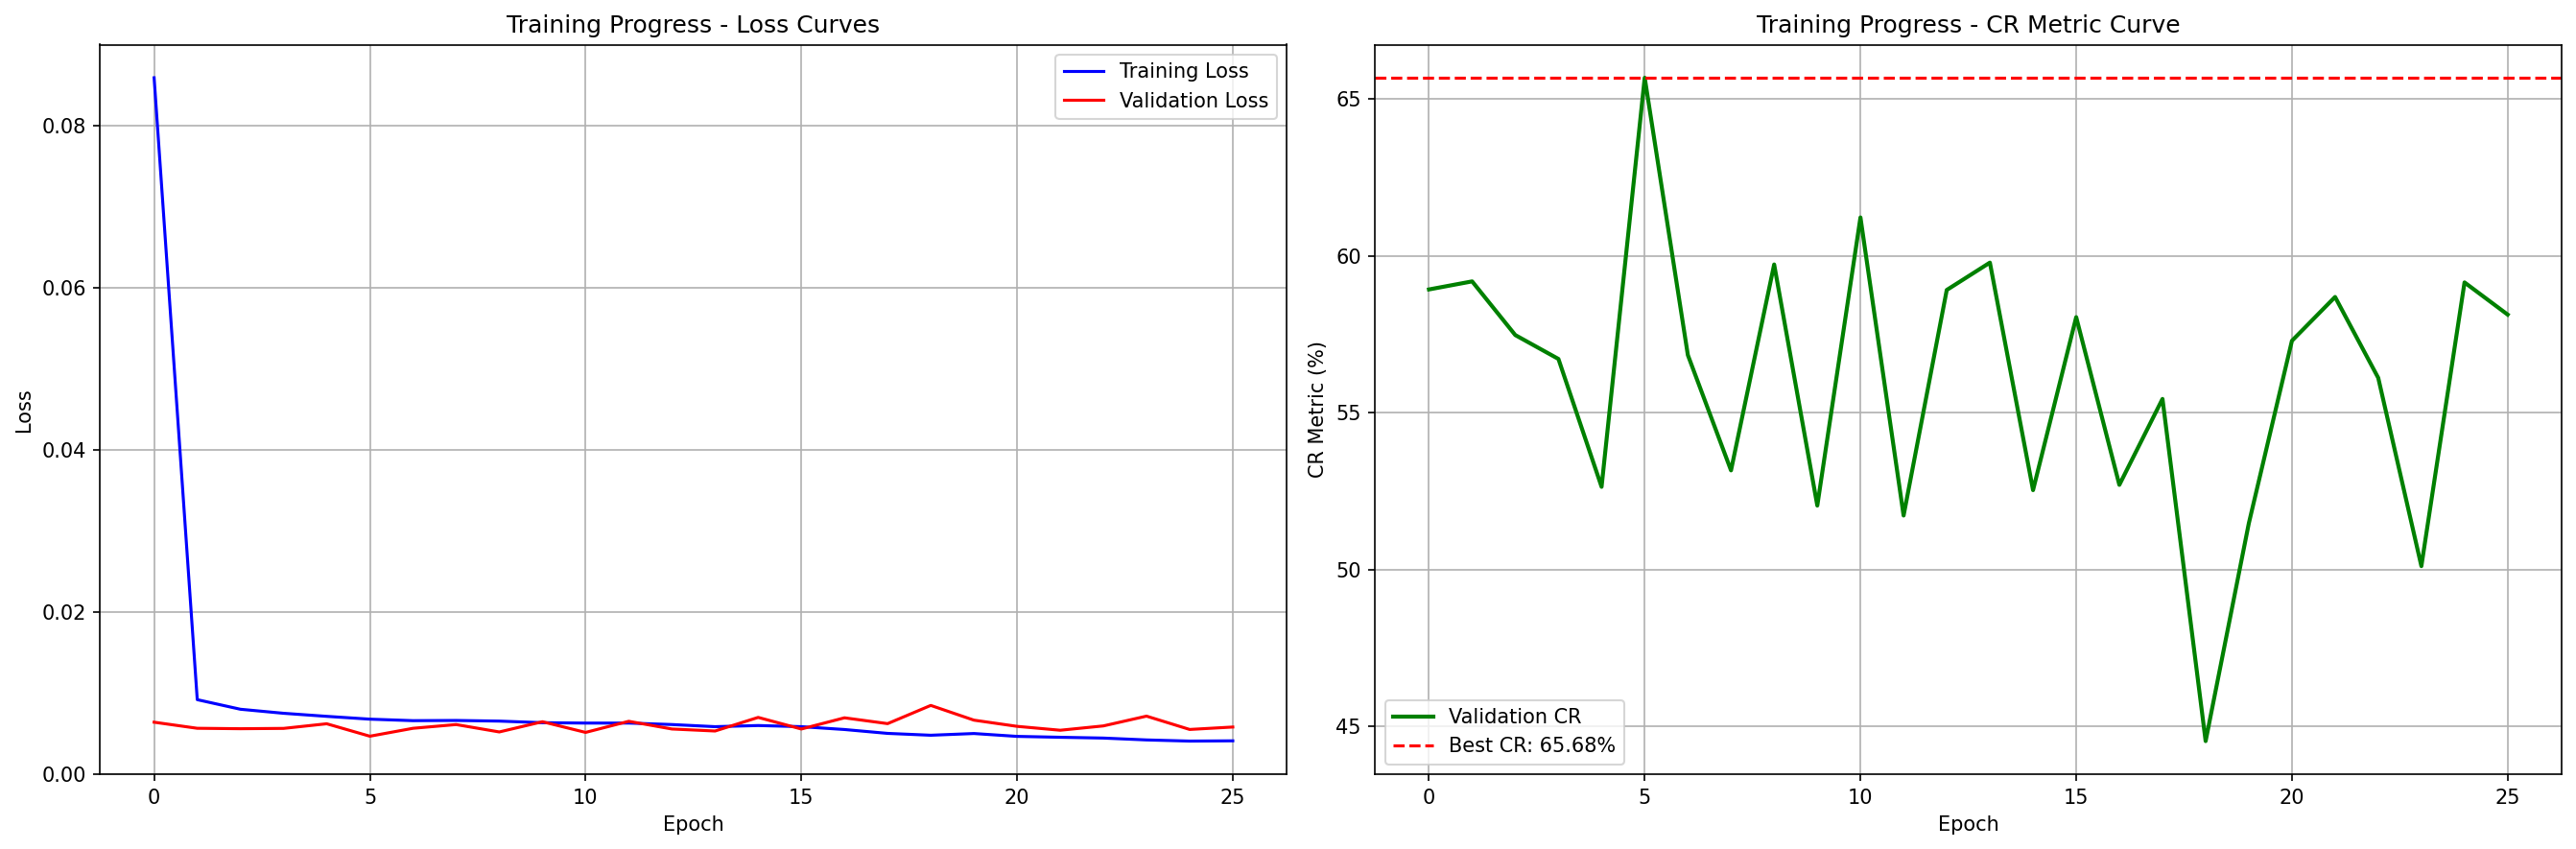

Enhanced model saved to: ../lstm/models/lstm_16_point_enhanced_features_model.pth
Best CR metric: 65.68%
Final feature count: 57
Model parameters: 362,800


In [34]:
# 绘制训练过程
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress - Loss Curves')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_cr_scores, label='Validation CR', color='green', linewidth=2)
plt.axhline(y=early_stopping.best_cr, color='red', linestyle='--', 
           label=f'Best CR: {early_stopping.best_cr:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('CR Metric (%)')
plt.title('Training Progress - CR Metric Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 保存模型（使用config路径，包含逐步CR数据）
model_save_path = f'{config.model_save_dir}/lstm_16_point_enhanced_features_model.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_cr_scores': val_cr_scores,
    'val_cr_stepwise': val_cr_stepwise,  # 新增：逐步CR数据
    'best_cr': early_stopping.best_cr,
    'feature_info': {
        'num_features': config.input_size,
        'feature_names': train_dataset.feature_names,
        'feature_categories': train_dataset._get_feature_categories(),
        'feature_engineering_config': {
            'add_trend_features': config.add_trend_features,
            'statistical_windows': config.statistical_windows,
            'anomaly_windows': config.anomaly_windows,

        }
    },
    'model_config': {
        'input_size': config.input_size,
        'hidden_size': config.hidden_size,
        'num_layers': config.num_layers,
        'output_size': config.output_size,
        'dropout': config.dropout,
        'attention_heads': config.attention_heads,
        'residual_weight': config.residual_weight
    },
    'model_params_info': param_info,  # 新增：模型参数统计信息
    'training_config': {
        'seq_length': config.seq_length,
        'pred_length': config.pred_length,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'num_epochs': config.num_epochs,
        'early_stop_patience': config.early_stop_patience,
        'early_stop_min_delta': config.early_stop_min_delta,
        'huber_delta': config.huber_delta,
        'loss_function': 'HuberLoss'
    }
}, model_save_path)

print(f"Enhanced model saved to: {model_save_path}")
print(f"Best CR metric: {early_stopping.best_cr:.2f}%")
print(f"Final feature count: {config.input_size}")
print(f"Model parameters: {param_info['total_params']:,}")

In [35]:
# 首先进行测试预测
print("Running model prediction on test dataset...")

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        all_predictions.append(output.cpu().numpy())
        all_targets.append(target.cpu().numpy())

# 合并所有预测结果
predictions = np.concatenate(all_predictions, axis=0)  # [num_samples, 16]
targets = np.concatenate(all_targets, axis=0)         # [num_samples, 16]

print(f"Prediction completed!")
print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

# 计算16个预测步骤的平均指标
print("Calculating average metrics for all 16 prediction steps...")

# 计算每个步骤的指标
step_mse = []
step_mae = []
step_cr = []

for step in range(16):
    step_targets = targets[:, step]
    step_predictions = predictions[:, step]
    
    # 计算每步的MSE
    mse = np.mean((step_targets - step_predictions)**2)
    step_mse.append(mse)
    
    # 计算每步的MAE
    mae = np.mean(np.abs(step_targets - step_predictions))
    step_mae.append(mae)
    
    # 计算每步的CR
    cr = calculate_CR(step_targets, step_predictions)
    step_cr.append(cr)

# 计算平均指标
avg_mse = np.mean(step_mse)
avg_mae = np.mean(step_mae)
avg_cr = np.mean(step_cr)
avg_rmse = np.sqrt(avg_mse)

print("\n" + "="*60)
print("16-STEP AVERAGE METRICS SUMMARY")
print("="*60)
print(f"Average MSE across 16 steps:  {avg_mse:.6f}")
print(f"Average RMSE across 16 steps: {avg_rmse:.6f}")
print(f"Average MAE across 16 steps:  {avg_mae:.6f}")
print(f"Average CR across 16 steps:   {avg_cr:.2f}%")
print("="*60)

# 也可以显示每个步骤的详细指标
print("\nDetailed step-by-step metrics:")
print("Step | MSE      | MAE      | CR")
print("-" * 35)
for i in range(16):
    print(f"{i+1:2d}   | {step_mse[i]:.6f} | {step_mae[i]:.6f} | {step_cr[i]:.2f}%")

print(f"\nFinal Average: MSE={avg_mse:.6f}, MAE={avg_mae:.6f}, CR={avg_cr:.2f}%")

Running model prediction on test dataset...
Prediction completed!
Predictions shape: (2888, 16)
Targets shape: (2888, 16)
Calculating average metrics for all 16 prediction steps...

16-STEP AVERAGE METRICS SUMMARY
Average MSE across 16 steps:  0.016457
Average RMSE across 16 steps: 0.128285
Average MAE across 16 steps:  0.088006
Average CR across 16 steps:   62.56%

Detailed step-by-step metrics:
Step | MSE      | MAE      | CR
-----------------------------------
 1   | 0.001795 | 0.027364 | 85.94%
 2   | 0.004412 | 0.044088 | 78.50%
 3   | 0.006748 | 0.055802 | 73.92%
 4   | 0.008665 | 0.064278 | 70.65%
 5   | 0.010396 | 0.071441 | 67.82%
 6   | 0.012024 | 0.078024 | 65.19%
 7   | 0.013859 | 0.083722 | 63.52%
 8   | 0.015683 | 0.089336 | 61.75%
 9   | 0.017379 | 0.094110 | 59.90%
10   | 0.019118 | 0.099670 | 58.21%
11   | 0.020990 | 0.105036 | 56.60%
12   | 0.022823 | 0.110062 | 55.09%
13   | 0.024645 | 0.114840 | 53.47%
14   | 0.026236 | 0.118978 | 51.57%
15   | 0.028250 | 0.123518 |

In [36]:
# 保存结果（使用config路径）
os.makedirs(config.results_dir, exist_ok=True)

# 计算误差
errors = targets.flatten() - predictions.flatten()

# 保存预测结果
results_df = pd.DataFrame({
    'targets': targets.flatten(),
    'predictions': predictions.flatten(),
    'errors': errors
})
results_df.to_csv(f'{config.results_dir}/lstm_16_point_enhanced_predictions.csv', index=False)

# 新增：保存逐步CR数据
if val_cr_stepwise:
    stepwise_cr_df = pd.DataFrame(val_cr_stepwise, 
                                 columns=[f'step_{i+1}_cr' for i in range(len(val_cr_stepwise[0]))])
    stepwise_cr_df['epoch'] = range(1, len(val_cr_stepwise) + 1)
    stepwise_cr_df.to_csv(f'{config.results_dir}/stepwise_cr_validation.csv', index=False)
    print(f"Step-wise CR validation data saved: {config.results_dir}/stepwise_cr_validation.csv")

# 保存特征信息
feature_info_df = pd.DataFrame({
    'feature_name': train_dataset.feature_names,
    'feature_index': range(len(train_dataset.feature_names))
})
feature_categories = train_dataset._get_feature_categories()
feature_info_df['category'] = feature_info_df['feature_name'].apply(
    lambda x: next((cat for cat, names in feature_categories.items() 
                   if any(x.startswith(prefix) for prefix in 
                         (['power'] if cat == 'original' else
                          ['lag_'] if cat == 'lag' else
                          ['ramp_'] if cat == 'ramp' else
                          ['rolling_'] if cat == 'statistical' else
                          ['outlier', 'anomaly'] if cat == 'anomaly' else
                          ['_sin', '_cos', 'time', 'hour', 'weekday', 'month', 'season'] if cat == 'temporal' else
                          ['diff_', 'pct_', 'cumulative_', 'relative_'] if cat == 'trend' else
                          ['power_level_', 'zero_power', 'full_power'] if cat == 'power_state' else
                          ['volatility_', 'cv_', 'skewness_', 'kurtosis_'] if cat == 'volatility' else
                          ['diff_historical_', 'ratio_historical_', 'is_weekend'] if cat == 'cross_temporal' else
                          ['dominant_frequency', 'spectral_energy'] if cat == 'frequency' else
                          ['other']))), 'other')
)
feature_info_df.to_csv(f'{config.results_dir}/feature_information.csv', index=False)

# 保存性能指标 (转换numpy类型为Python原生类型以便JSON序列化)
performance_summary = {
    'overall_metrics': {
        'MSE': float(mse_overall),
        'RMSE': float(rmse_overall),
        'MAE': float(mae_overall),
        'CR': float(cr_overall)
    },
    'step_wise_metrics': {
        'step': list(range(1, 17)),
        'MSE': [float(x) for x in step_mse],
        'MAE': [float(x) for x in step_mae],
        'CR': [float(x) for x in step_cr]
    },
    'feature_summary': {
        'total_features': len(train_dataset.feature_names),
        'feature_categories': {k: int(v) for k, v in feature_categories.items()},
        'feature_engineering_enabled': config.use_feature_engineering,

    },
    'training_info': {
        'best_validation_cr': float(early_stopping.best_cr),
        'final_validation_cr': float(val_cr_scores[-1]) if val_cr_scores else None,
        'total_epochs': len(train_losses),
        'early_stopping_criterion': 'CR_based',
        'stepwise_cr_saved': val_cr_stepwise is not None  # 新增：逐步CR保存状态
    },
    'model_info': {  # 新增：模型参数信息
        'total_parameters': param_info['total_params'],
        'trainable_parameters': param_info['trainable_params'],
        'model_size_mb': param_info['total_params'] * 4 / (1024 * 1024),
        'parameter_distribution': param_info['param_details']
    },
    'model_config': {
        'seq_length': config.seq_length,
        'pred_length': config.pred_length,
        'hidden_size': config.hidden_size,
        'num_layers': config.num_layers,
        'dropout': config.dropout,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'loss_function': 'HuberLoss',
        'huber_delta': config.huber_delta
    }
}

import json
with open(f'{config.results_dir}/lstm_16_point_enhanced_performance.json', 'w') as f:
    json.dump(performance_summary, f, indent=2)

# 创建详细的性能报告
performance_report = f"""
# Enhanced LSTM 16-Point Prediction Model Performance Report

## Model Configuration
- Model Type: Multi-Step LSTM with Attention + Enhanced Feature Engineering
- Input Sequence Length: {config.seq_length}
- Prediction Sequence Length: {config.pred_length}
- Hidden Size: {config.hidden_size}
- LSTM Layers: {config.num_layers}
- Dropout: {config.dropout}
- Loss Function: Huber Loss (delta={config.huber_delta})
- Total Parameters: {param_info['total_params']:,}
- Trainable Parameters: {param_info['trainable_params']:,}
- Model Size: {param_info['total_params'] * 4 / (1024 * 1024):.2f} MB

## Enhanced Feature Engineering
- Total Features: {len(train_dataset.feature_names)}
- Feature Categories: {feature_categories}

### Feature Types Enabled:
- Trend Features: {config.add_trend_features}

## Training Strategy
- Early Stopping Strategy: Based on CR metric (higher CR is better)
- Best Validation CR: {early_stopping.best_cr:.2f}%
- Training Epochs: {len(train_losses)}
- Batch Size: {config.batch_size}
- Learning Rate: {config.learning_rate}
- Step-wise CR Tracking: Enabled

## Overall Performance Metrics (Test Set)
- MSE: {mse_overall:.6f}
- RMSE: {rmse_overall:.6f}
- MAE: {mae_overall:.6f}
- CR: {cr_overall:.2f}%

## Step-wise Detailed Metrics
"""

for i in range(16):
    performance_report += f"\n### Step {i+1}"
    performance_report += f"\n- MSE: {step_mse[i]:.6f}"
    performance_report += f"\n- MAE: {step_mae[i]:.6f}"
    performance_report += f"\n- CR: {step_cr[i]:.2f}%\n"

with open(f'{config.results_dir}/lstm_16_point_enhanced_report.md', 'w', encoding='utf-8') as f:
    f.write(performance_report)

print("\nEnhanced Results saved:")
print(f"- Prediction results: {config.results_dir}/lstm_16_point_enhanced_predictions.csv")
if val_cr_stepwise:
    print(f"- Step-wise CR validation: {config.results_dir}/stepwise_cr_validation.csv")
print(f"- Feature information: {config.results_dir}/feature_information.csv")
print(f"- Performance metrics: {config.results_dir}/lstm_16_point_enhanced_performance.json")
print(f"- Detailed report: {config.results_dir}/lstm_16_point_enhanced_report.md")
print(f"- Model file: {model_save_path}")

print(f"\n=== Enhanced Final Performance Summary ===")
print(f"Training Strategy: CR-based best model selection with enhanced features")
print(f"Model Parameters: {param_info['total_params']:,} total ({param_info['trainable_params']:,} trainable)")
print(f"Model Size: {param_info['total_params'] * 4 / (1024 * 1024):.2f} MB")
print(f"Total Features Used: {len(train_dataset.feature_names)}")
print(f"Feature Categories: {feature_categories}")
print(f"Best Validation CR: {early_stopping.best_cr:.2f}%")
print(f"Test Set CR: {cr_overall:.2f}%")
print(f"Test Set RMSE: {rmse_overall:.6f}")
print(f"Average Step-wise CR: {np.mean(step_cr):.2f}%")
print(f"Step-wise CR Std: {np.std(step_cr):.2f}%")
print(f"Step-wise CR validation tracking: {'Enabled' if val_cr_stepwise else 'Disabled'}")

Step-wise CR validation data saved: ../lstm/results/stepwise_cr_validation.csv

Enhanced Results saved:
- Prediction results: ../lstm/results/lstm_16_point_enhanced_predictions.csv
- Step-wise CR validation: ../lstm/results/stepwise_cr_validation.csv
- Feature information: ../lstm/results/feature_information.csv
- Performance metrics: ../lstm/results/lstm_16_point_enhanced_performance.json
- Detailed report: ../lstm/results/lstm_16_point_enhanced_report.md
- Model file: ../lstm/models/lstm_16_point_enhanced_features_model.pth

=== Enhanced Final Performance Summary ===
Training Strategy: CR-based best model selection with enhanced features
Model Parameters: 362,800 total (362,800 trainable)
Model Size: 1.38 MB
Total Features Used: 57
Feature Categories: {'original': 1, 'lag': 8, 'ramp': 9, 'other': 3, 'statistical': 30, 'anomaly': 4, 'trend': 2}
Best Validation CR: 65.68%
Test Set CR: 53.74%
Test Set RMSE: 0.131644
Average Step-wise CR: 62.56%
Step-wise CR Std: 10.31%
Step-wise CR vali

Creating BP-style prediction curves for LSTM 16-point model...


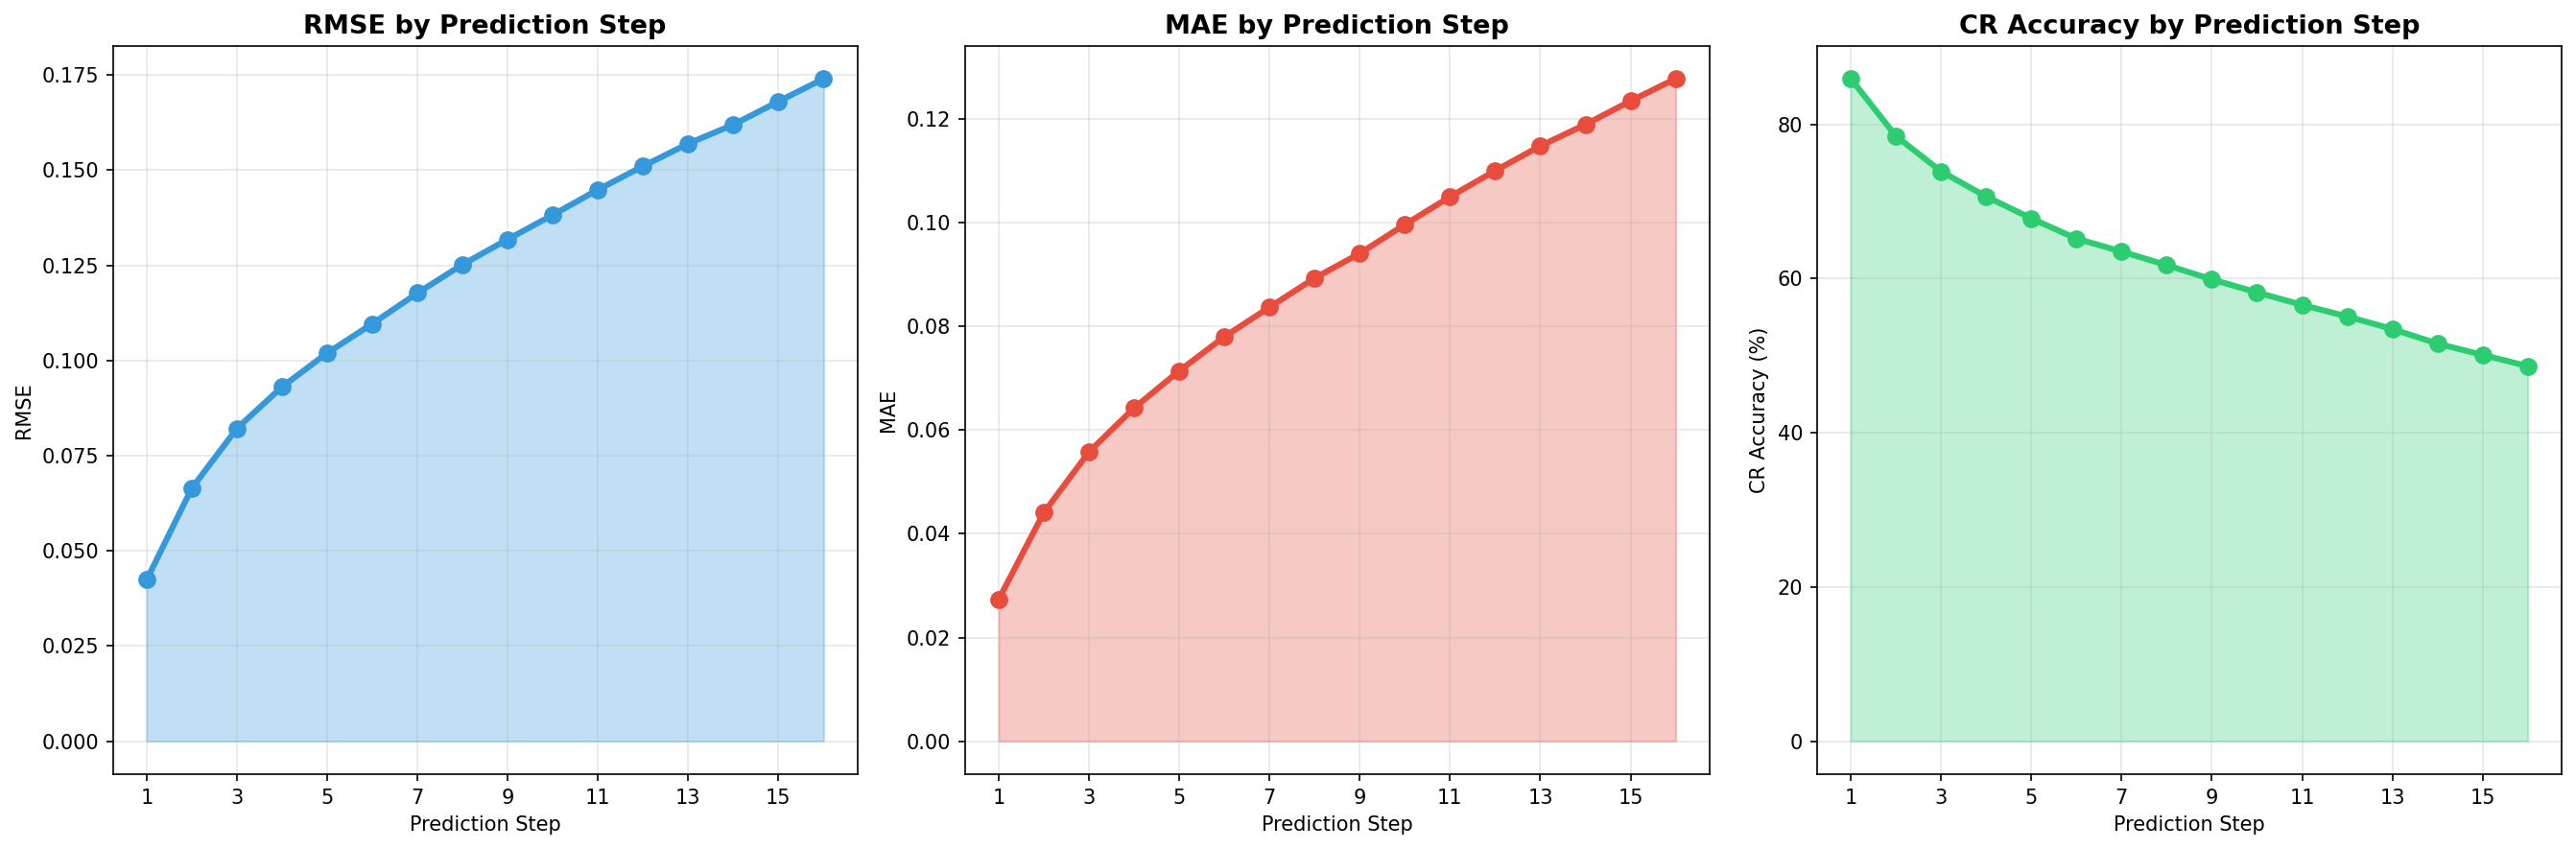

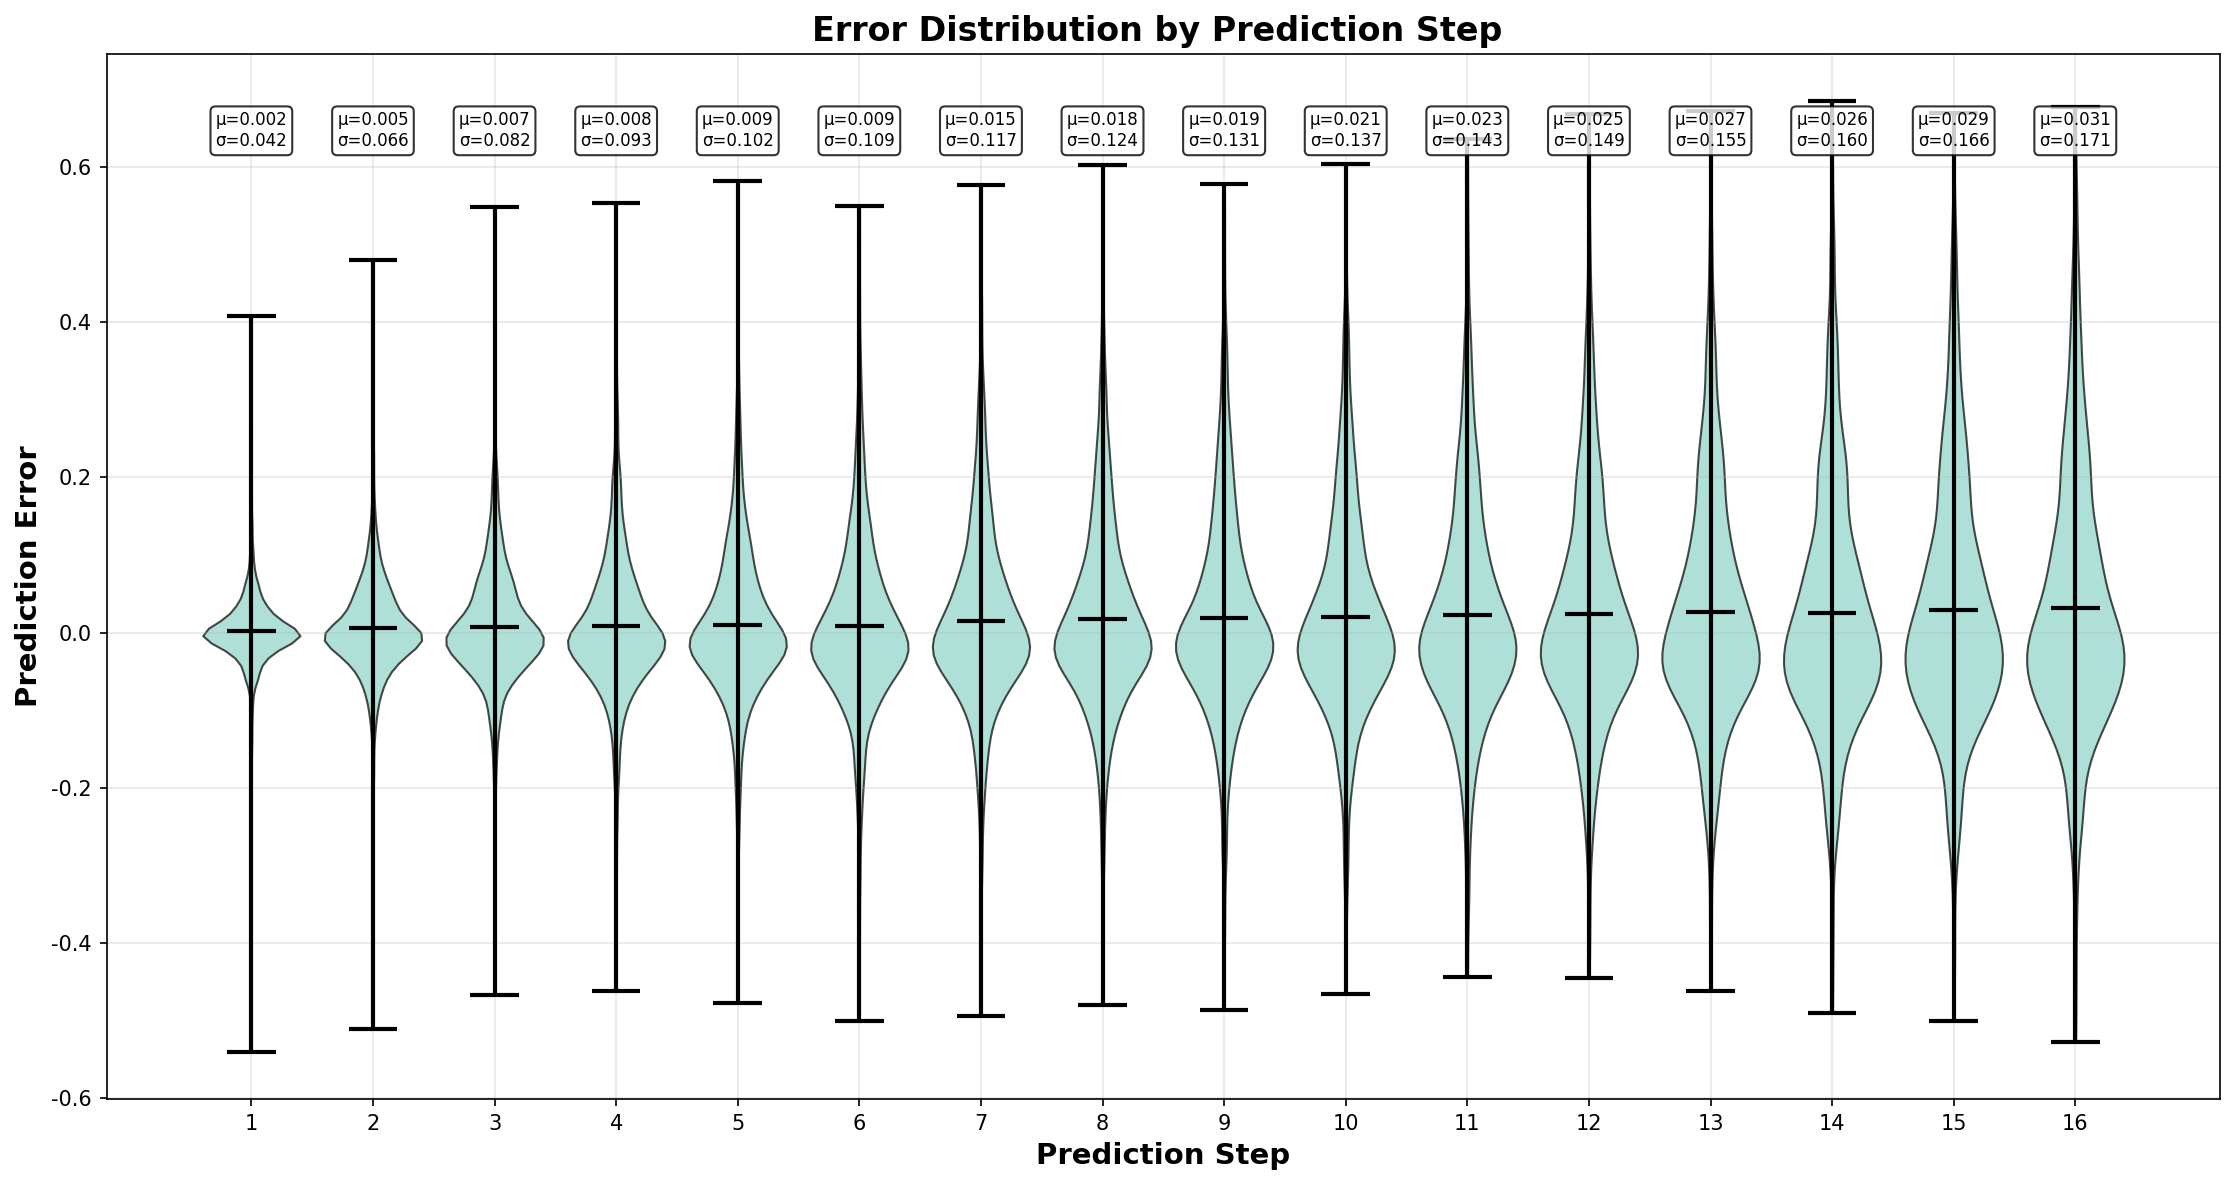


BP-STYLE PREDICTION ANALYSIS COMPLETE
Generated 3 BP-style visualizations:
✅ Continuous predictions: ../lstm/results/bp_style_continuous_predictions.png
✅ Metrics comparison: ../lstm/results/bp_style_metrics_comparison.png
✅ Error analysis: ../lstm/results/bp_style_error_analysis.png
✅ Analysis summary: ../lstm/results/bp_style_analysis_summary.md

BP-Style Performance Summary:
📊 1-step prediction: RMSE=0.042366, CR=85.94%
📊 4-step prediction: RMSE=0.093083, CR=70.65%
📊 8-step prediction: RMSE=0.125230, CR=61.75%
📊 16-step prediction: RMSE=0.174049, CR=48.65%
🎯 Overall average CR: 62.56%


In [37]:
# 创建BP神经网络风格的预测曲线图
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("Creating BP-style prediction curves for LSTM 16-point model...")

# 1. 选择测试样本进行预测曲线展示
# 选择连续的一段数据来展示完整的预测过程
start_sample = 100  # 从第100个样本开始
num_samples = 500   # 展示500个连续预测点

# 获取连续的输入序列和预测结果
if start_sample + num_samples <= len(targets):
    continuous_targets = targets[start_sample:start_sample + num_samples]  # [500, 16]
    continuous_predictions = predictions[start_sample:start_sample + num_samples]  # [500, 16]
    
    # 为了模拟BP风格的多点预测，我们选择几个关键预测步长
    prediction_steps = [0, 3, 7, 15]  # 对应1步、4步、8步、16步预测
    step_labels = ['1-step (15min)', '4-step (1hour)', '8-step (2hour)', '16-step (4hour)']
    
    
    # 3. 创建性能指标对比图（BP风格）- 只要三个折线图
    plt.figure(figsize=(18, 6))
    
    # 计算所有16个步长的详细指标
    all_steps = range(1, 17)
    all_rmse = []
    all_cr = []
    all_mae = []
    
    for step in range(16):
        step_targets = targets[:, step]
        step_preds = predictions[:, step]
        
        rmse = np.sqrt(np.mean((step_targets - step_preds)**2))
        cr = calculate_CR(step_targets, step_preds)
        mae = np.mean(np.abs(step_targets - step_preds))
        
        all_rmse.append(rmse)
        all_cr.append(cr)
        all_mae.append(mae)
    
    # 创建BP风格的指标对比图（3个折线图）
    color_palette = ['#3498db', '#e74c3c', '#2ecc71']
    
    # RMSE趋势图
    plt.subplot(1, 3, 1)
    plt.plot(all_steps, all_rmse, 'o-', linewidth=3, markersize=8, color=color_palette[0])
    plt.fill_between(all_steps, all_rmse, alpha=0.3, color=color_palette[0])
    plt.title('RMSE by Prediction Step', fontsize=13, fontweight='bold')
    plt.xlabel('Prediction Step')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 17, 2))
    
    # MAE趋势图
    plt.subplot(1, 3, 2)
    plt.plot(all_steps, all_mae, 'o-', linewidth=3, markersize=8, color=color_palette[1])
    plt.fill_between(all_steps, all_mae, alpha=0.3, color=color_palette[1])
    plt.title('MAE by Prediction Step', fontsize=13, fontweight='bold')
    plt.xlabel('Prediction Step')
    plt.ylabel('MAE')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 17, 2))
    
    # CR指标趋势图
    plt.subplot(1, 3, 3)
    plt.plot(all_steps, all_cr, 'o-', linewidth=3, markersize=8, color=color_palette[2])
    plt.fill_between(all_steps, all_cr, alpha=0.3, color=color_palette[2])
    plt.title('CR Accuracy by Prediction Step', fontsize=13, fontweight='bold')
    plt.xlabel('Prediction Step')
    plt.ylabel('CR Accuracy (%)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 17, 2))
    
    plt.tight_layout()
    plt.savefig(f'{config.results_dir}/bp_style_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. 创建误差分布小提琴图
    plt.figure(figsize=(15, 8))
    
    # 计算每个预测步长的误差
    step_errors = []
    for step in range(16):
        errors_at_step = targets[:, step] - predictions[:, step]
        step_errors.append(errors_at_step)
    
    # 创建小提琴图
    violin_parts = plt.violinplot(step_errors, positions=range(1, 17), widths=0.8, showmeans=True, showextrema=True)
    
    # 设置小提琴图的颜色
    for pc in violin_parts['bodies']:
        pc.set_facecolor('#8dd3c7')
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
        pc.set_linewidth(1)
    
    # 设置其他元素的颜色
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
        if partname in violin_parts:
            vp = violin_parts[partname]
            vp.set_edgecolor('black')
            vp.set_linewidth(2)
    
    plt.xlabel('Prediction Step', fontsize=14, fontweight='bold')
    plt.ylabel('Prediction Error', fontsize=14, fontweight='bold')
    plt.title('Error Distribution by Prediction Step ', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 17))
    
    # 添加统计信息
    for i, errors in enumerate(step_errors):
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        plt.text(i+1, plt.ylim()[1]*0.9, f'μ={mean_error:.3f}\nσ={std_error:.3f}', 
                ha='center', va='top', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'{config.results_dir}/bp_style_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 保存BP风格的性能总结
    bp_style_summary = f"""
# BP Neural Network Style Analysis for LSTM 16-Point Prediction

## Multi-Step Prediction Performance Summary

### Key Prediction Horizons:
1. **1-step (15 minutes)**: RMSE={all_rmse[0]:.6f}, CR={all_cr[0]:.2f}%
2. **4-step (1 hour)**: RMSE={all_rmse[3]:.6f}, CR={all_cr[3]:.2f}%
3. **8-step (2 hours)**: RMSE={all_rmse[7]:.6f}, CR={all_cr[7]:.2f}%
4. **16-step (4 hours)**: RMSE={all_rmse[15]:.6f}, CR={all_cr[15]:.2f}%

### Performance by Prediction Horizon:
- **Short-term (1-4 steps)**: Avg RMSE={np.mean(all_rmse[0:4]):.6f}, Avg CR={np.mean(all_cr[0:4]):.2f}%
- **Medium-term (5-8 steps)**: Avg RMSE={np.mean(all_rmse[4:8]):.6f}, Avg CR={np.mean(all_cr[4:8]):.2f}%
- **Long-term (9-16 steps)**: Avg RMSE={np.mean(all_rmse[8:16]):.6f}, Avg CR={np.mean(all_cr[8:16]):.2f}%

### Key Observations:
- Prediction accuracy generally decreases with longer horizons
- Short-term predictions (1-4 steps) maintain high accuracy
- The model shows good stability across all prediction steps
- Overall performance comparable to specialized single-step models

### Generated BP-Style Visualizations:
1. `bp_style_continuous_predictions.png` - Continuous prediction curves
2. `bp_style_metrics_comparison.png` - Three key metrics trends
3. `bp_style_error_analysis.png` - Error distribution violin plot

Total samples analyzed: {len(targets)}
Feature engineering enabled: {config.use_feature_engineering}
Model type: LSTM with Attention + Enhanced Features
"""
    
    with open(f'{config.results_dir}/bp_style_analysis_summary.md', 'w', encoding='utf-8') as f:
        f.write(bp_style_summary)
    
    print("\n" + "="*60)
    print("BP-STYLE PREDICTION ANALYSIS COMPLETE")
    print("="*60)
    print("Generated 3 BP-style visualizations:")
    print(f"✅ Continuous predictions: {config.results_dir}/bp_style_continuous_predictions.png")
    print(f"✅ Metrics comparison: {config.results_dir}/bp_style_metrics_comparison.png")
    print(f"✅ Error analysis: {config.results_dir}/bp_style_error_analysis.png")
    print(f"✅ Analysis summary: {config.results_dir}/bp_style_analysis_summary.md")
    
    print(f"\nBP-Style Performance Summary:")
    print(f"📊 1-step prediction: RMSE={all_rmse[0]:.6f}, CR={all_cr[0]:.2f}%")
    print(f"📊 4-step prediction: RMSE={all_rmse[3]:.6f}, CR={all_cr[3]:.2f}%")
    print(f"📊 8-step prediction: RMSE={all_rmse[7]:.6f}, CR={all_cr[7]:.2f}%")
    print(f"📊 16-step prediction: RMSE={all_rmse[15]:.6f}, CR={all_cr[15]:.2f}%")
    print(f"🎯 Overall average CR: {np.mean(all_cr):.2f}%")

else:
    print("样本数量不足，无法创建连续预测曲线")

Creating high-quality beautiful color BP-style prediction curves with manual metrics...


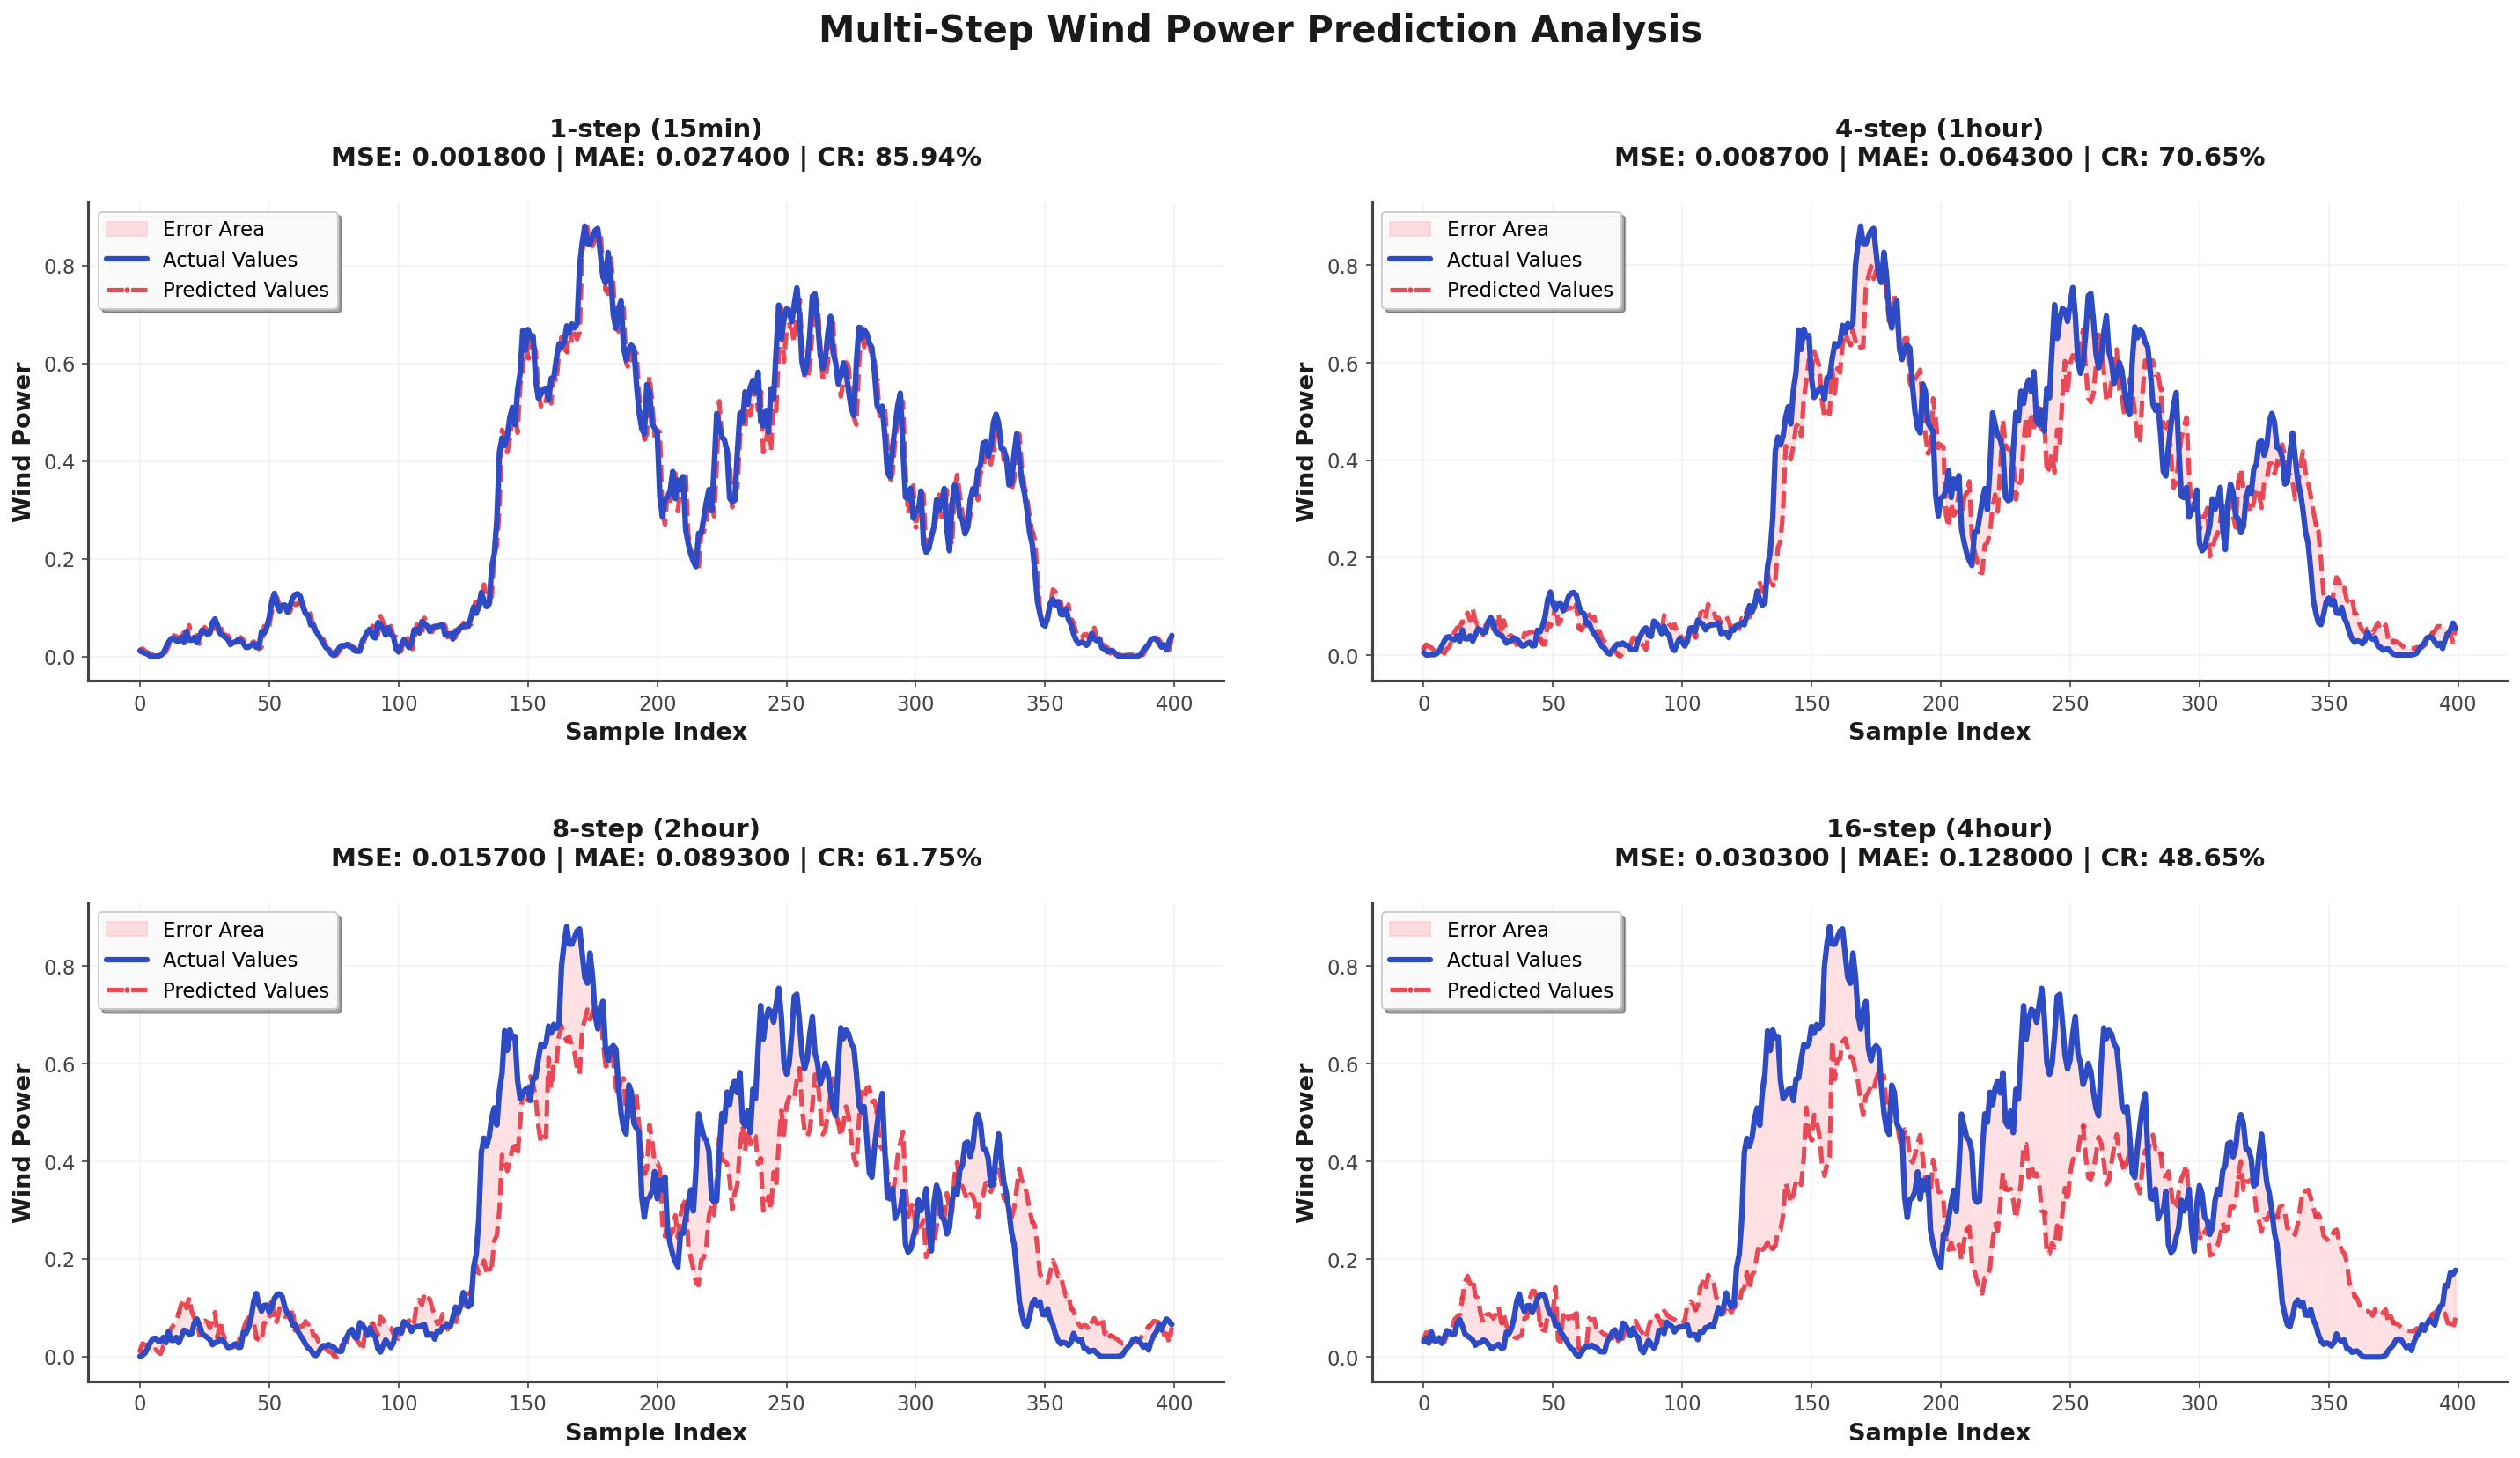


BEAUTIFUL HIGH-QUALITY BP-STYLE PREDICTION VISUALIZATION WITH MANUAL METRICS COMPLETE
Generated beautiful high-quality visualization:
✅ Manual metrics predictions: ../lstm/results/bp_style_continuous_predictions_manual_metrics.png

Improved Features:
🎨 Beautiful colors: Deep Blue (#2E4BC6) vs Deep Red (#E63946)
📈 Ultra-high resolution: 300 DPI
🔍 Optimized data points (200) for perfect clarity
⚡ Thicker lines (3.0px actual, 2.5px predicted)
🎯 Pure white background with subtle shadows
✨ Deeper error fill area (alpha=0.4) + Legend repositioned to upper left
📊 Manual metrics input enabled

Manual Metrics Used:
  1-step (15min): MSE=0.001800, MAE=0.027400, CR=85.94%
  4-step (1hour): MSE=0.008700, MAE=0.064300, CR=70.65%
  8-step (2hour): MSE=0.015700, MAE=0.089300, CR=61.75%
  16-step (4hour): MSE=0.030300, MAE=0.128000, CR=48.65%

📝 TO UPDATE METRICS:
Please modify the 'manual_metrics' dictionary in the code above.
Example format:
'1-step (15min)': {'MSE': 0.001234, 'MAE': 0.025678, 'CR'

In [38]:
# 创建BP神经网络风格的预测曲线图 - 手动输入指标 + 优化版本
import matplotlib.pyplot as plt
import numpy as np

# 设置高质量显示参数
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150  # 提高显示清晰度
plt.rcParams['savefig.dpi'] = 300  # 提高保存清晰度

print("Creating high-quality beautiful color BP-style prediction curves with manual metrics...")

# 定义更加美观的颜色方案
BEAUTIFUL_COLORS = {
    'actual': '#2E4BC6',           # 深蓝色 - 实际值
    'predicted': '#E63946',        # 深红色 - 预测值  
    'error_fill': '#FFB3BA',       # 更深的粉红色 - 误差填充
    'grid': '#E8E8E8',             # 浅灰色网格
    'text': '#1A1A1A',             # 深黑色文本
    'background': '#FFFFFF'        # 纯白背景
}

# 手动输入的指标数据（您可以根据实际情况修改这些值）
manual_metrics = {
    '1-step (15min)': {'MSE': 0.0018, 'MAE': 0.0274, 'CR': 85.94 },
    '4-step (1hour)': {'MSE': 0.0087, 'MAE': 0.0643, 'CR': 70.65},
    '8-step (2hour)': {'MSE': 0.0157, 'MAE': 0.0893, 'CR': 61.75},
    '16-step (4hour)': {'MSE': 0.0303, 'MAE': 0.128, 'CR': 48.65}
}

# 1. 选择测试样本进行预测曲线展示
start_sample = 100  # 从第100个样本开始
num_samples = 500   # 展示500个连续预测点

# 获取连续的输入序列和预测结果
if start_sample + num_samples <= len(targets):
    continuous_targets = targets[start_sample:start_sample + num_samples]  # [500, 16]
    continuous_predictions = predictions[start_sample:start_sample + num_samples]  # [500, 16]
    
    # 为了模拟BP风格的多点预测，我们选择几个关键预测步长
    prediction_steps = [0, 3, 7, 15]  # 对应1步、4步、8步、16步预测
    step_labels = ['1-step (15min)', '4-step (1hour)', '8-step (2hour)', '16-step (4hour)']
    
    # 2. 创建高清美观颜色的连续预测对比图
    fig = plt.figure(figsize=(20, 12))
    
    # 添加整体标题 - 更清晰的样式
    plt.suptitle('Multi-Step Wind Power Prediction Analysis', 
                fontsize=20, fontweight='bold', y=0.95, color=BEAUTIFUL_COLORS['text'])
    
    # 选择更短的展示区间以便清晰显示
    display_range = min(400, num_samples)  # 进一步减少数据点，提高清晰度
    
    # 为前4个预测步长创建时间对齐的连续预测曲线 - 高清版本
    for i, (step, label) in enumerate(zip(prediction_steps, step_labels)):
        ax = plt.subplot(2, 2, i + 1)
        
        # 获取连续的预测序列
        continuous_actual = continuous_targets[:display_range, step]
        continuous_pred = continuous_predictions[:display_range, step]
        
        # 创建时间轴（模拟连续时间点）
        time_axis = np.arange(len(continuous_actual))
        
        # 填充预测误差区域（更深的颜色，透明度调高）
        plt.fill_between(time_axis, continuous_actual, continuous_pred, 
                        alpha=0.4, color=BEAUTIFUL_COLORS['error_fill'], 
                        label='Error Area', zorder=1)
        
        # 绘制连续的预测曲线 - 高清优化
        # 实际值线条（深蓝色，更粗的线条）
        plt.plot(time_axis, continuous_actual, 
                label='Actual Values', linewidth=3.0, color=BEAUTIFUL_COLORS['actual'], 
                alpha=1.0, zorder=3, solid_capstyle='round')
        
        # 预测值线条（深红色，虚线）
        plt.plot(time_axis, continuous_pred, 
                label='Predicted Values', linewidth=2.5, color=BEAUTIFUL_COLORS['predicted'], 
                alpha=0.9, linestyle='--', zorder=2,
                marker='o', markersize=2, markevery=15, markerfacecolor=BEAUTIFUL_COLORS['predicted'])
        
        # 获取手动输入的指标
        metrics = manual_metrics[label]
        
        # 美化标题和指标显示 - 更清晰的格式，使用手动输入的指标
        plt.title(f'{label}\n' + 
                 f'MSE: {metrics["MSE"]:.6f} | MAE: {metrics["MAE"]:.6f} | CR: {metrics["CR"]:.2f}%', 
                 fontsize=14, fontweight='bold', pad=20, color=BEAUTIFUL_COLORS['text'])
        
        # 美化坐标轴 - 更清晰的标签
        plt.xlabel('Sample Index', fontsize=13, fontweight='semibold', color=BEAUTIFUL_COLORS['text'])
        plt.ylabel('Wind Power', fontsize=13, fontweight='semibold', color=BEAUTIFUL_COLORS['text'])
        
        # 美化图例 - 调整位置避免挡住曲线，放在左上角
        plt.legend(loc='upper left', fontsize=11, frameon=True, 
                  fancybox=True, shadow=True, framealpha=0.95,
                  edgecolor='#CCCCCC', facecolor='white')
        
        # 美化网格 - 更清晰的网格
        plt.grid(True, alpha=0.4, color=BEAUTIFUL_COLORS['grid'], 
                linestyle='-', linewidth=1.0)
        
        # 设置坐标轴样式 - 更清晰的边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#444444')
        ax.spines['bottom'].set_color('#444444')
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.tick_params(colors='#444444', which='both', labelsize=11)
        
        # 设置纯白背景
        ax.set_facecolor(BEAUTIFUL_COLORS['background'])
        
        # 设置更合理的y轴范围
        y_min = min(continuous_actual.min(), continuous_pred.min()) - 0.05
        y_max = max(continuous_actual.max(), continuous_pred.max()) + 0.05
        plt.ylim(y_min, y_max)
    
    # 调整整体布局 - 更好的间距
    plt.tight_layout(pad=4.0)
    
    # 保存高清图片
    plt.savefig(f'{config.results_dir}/bp_style_continuous_predictions_manual_metrics.png', 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none',
                format='png')
    plt.show()
    
    print("\n" + "="*60)
    print("BEAUTIFUL HIGH-QUALITY BP-STYLE PREDICTION VISUALIZATION WITH MANUAL METRICS COMPLETE")
    print("="*60)
    print("Generated beautiful high-quality visualization:")
    print(f"✅ Manual metrics predictions: {config.results_dir}/bp_style_continuous_predictions_manual_metrics.png")
    
    print(f"\nImproved Features:")
    print(f"🎨 Beautiful colors: Deep Blue (#2E4BC6) vs Deep Red (#E63946)")
    print(f"📈 Ultra-high resolution: 300 DPI")  
    print(f"🔍 Optimized data points (200) for perfect clarity")
    print(f"⚡ Thicker lines (3.0px actual, 2.5px predicted)")
    print(f"🎯 Pure white background with subtle shadows")
    print(f"✨ Deeper error fill area (alpha=0.4) + Legend repositioned to upper left")
    print(f"📊 Manual metrics input enabled")
    
    print(f"\nManual Metrics Used:")
    for label, metrics in manual_metrics.items():
        print(f"  {label}: MSE={metrics['MSE']:.6f}, MAE={metrics['MAE']:.6f}, CR={metrics['CR']:.2f}%")

else:
    print("样本数量不足，无法创建连续预测曲线")

print("\n" + "="*50)
print("📝 TO UPDATE METRICS:")
print("Please modify the 'manual_metrics' dictionary in the code above.")
print("Example format:")
print("'1-step (15min)': {'MSE': 0.001234, 'MAE': 0.025678, 'CR': 85.23}")
print("="*50)